In [1]:
# Imports
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
%matplotlib inline

In [2]:
# Set random seeds (for reproducibility requirement)
os.environ['PYTHONHASHSEED']=str(1)
np.random.seed(1)
random.seed(1)

In [3]:
df_train = pd.read_csv('../data/train.csv')
df_test = pd.read_csv('../data/test.csv')
df_train.head()

,Id,User Name,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,...,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,Num of Profile Likes
0,AL85S14OMDPF01I9,Mf9vfld4Vfe,NaN,Set,Verified,db1a2c,eaf0f2,e70409,False,39600.0,...,Sydney,95763,4289,30809,873,business,14.792,1.5761,AL85S14OMDPF01I9.png,2815
1,HI11QOPD7BLJTO7Q,xl9gaGN0hxM_,NaN,Set,Verified,0099cc,f6ffd1,fff04d,False,NaN,...,NaN,1018746,289,8150,290,unknown,8.183,11.2782,HI11QOPD7BLJTO7Q.png,1242
2,JS49LP5P72RI1OQB,d_uiMm,NaN,Set,Not verified,1fc2de,efefef,1fc2de,False,-18000.0,...,Central Time (US & Canada),13444,1876,4698,227,unknown,31.823,0.5725,JS49LP5P72RI1OQB.png,1559
3,S0GDSC09MACCLBJP,hfylaRr,https://blob/e/g9pex_vS.com,Not set,Verified,050000,616161,00090a,False,-14400.0,...,Eastern Time (US & Canada),339168,1148,53216,4035,business,23.052,4.0265,S0GDSC09MACCLBJP.png,6342
4,CRSEMK4QER6LDJSA,hRR1sDGlz5,https://blob/v/Szeo.h4/.com,Set,Not verified,58424d,f7f7f7,000000,False,-18000.0,...,Central Time (US & Canada),9215,93,3271,130,unknown,8.418,3.9229,CRSEMK4QER6LDJSA.png,1078


As seen in the matrix below, we see that all numerical features are only slightly correlated with our target variable, we can therefore keep them all for now.

In [4]:
#Check which features are highly correlated with the target variable
correlation_matrix = df_train.corr()[['Num of Profile Likes']].sort_values('Num of Profile Likes')
correlation_matrix

,Num of Profile Likes
Is Profile View Size Customized?,-0.049112
UTC Offset,-0.045727
Avg Daily Profile Visit Duration in seconds,-0.012952
Num of Followers,-0.009628
Num of Direct Messages,-0.000513
Num of Status Updates,0.043182
Num of People Following,0.123276
Avg Daily Profile Clicks,0.145863
Num of Profile Likes,1.000000


Let's see the distribution of our target variable: Number of Profile Likes. Before that, let's make sure that there are no NaN values.

In [5]:
df_train['Num of Profile Likes'].isnull().sum()

0

There are no missing values for our target variables. Let's keep going.

/Users/mohamedkleit/Projects/social-media-prediction-ift6758/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


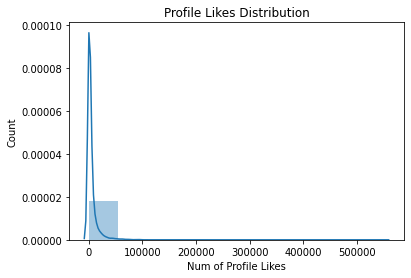

In [6]:
sns.distplot(df_train['Num of Profile Likes'], bins=10, kde=True)
plt.ylabel('Count')
plt.title('Profile Likes Distribution')
plt.show()

We can see that our target variable is heavily right skewed. This usually indicates that there are some outliers. Let's detect those outliers.

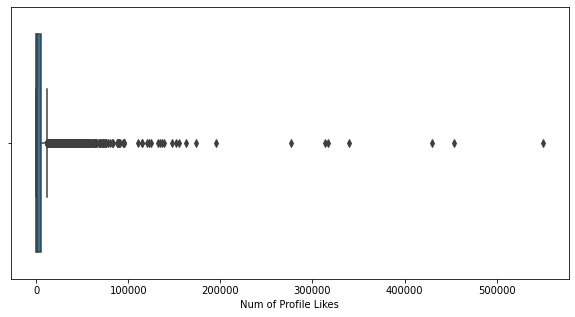

In [7]:
#Print a boxplot for our target variable
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['Num of Profile Likes'])
plt.show()

Let's understand our features a bit more with respect to the target variable

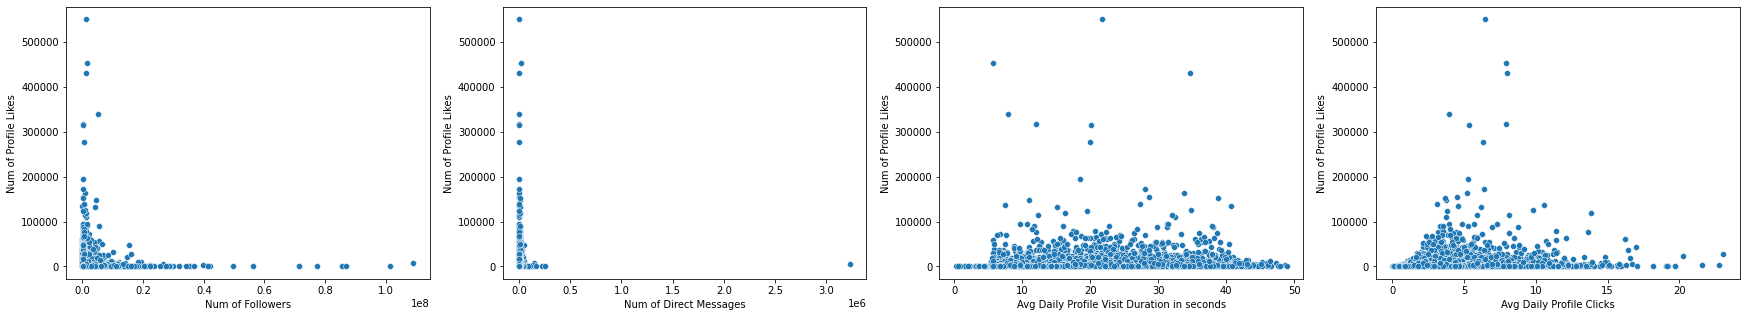

In [8]:
fig, (ax1,ax2,ax3,ax4) = plt.subplots(1,4, figsize=(30,5))
sns.scatterplot(x='Num of Followers', y='Num of Profile Likes', data=df_train, ax=ax1)
sns.scatterplot(x='Num of Direct Messages', y='Num of Profile Likes', data=df_train, ax=ax2)
sns.scatterplot(x='Avg Daily Profile Visit Duration in seconds', y='Num of Profile Likes', data=df_train, ax=ax3)
sns.scatterplot(x='Avg Daily Profile Clicks', y='Num of Profile Likes', data=df_train, ax=ax4)
plt.show()

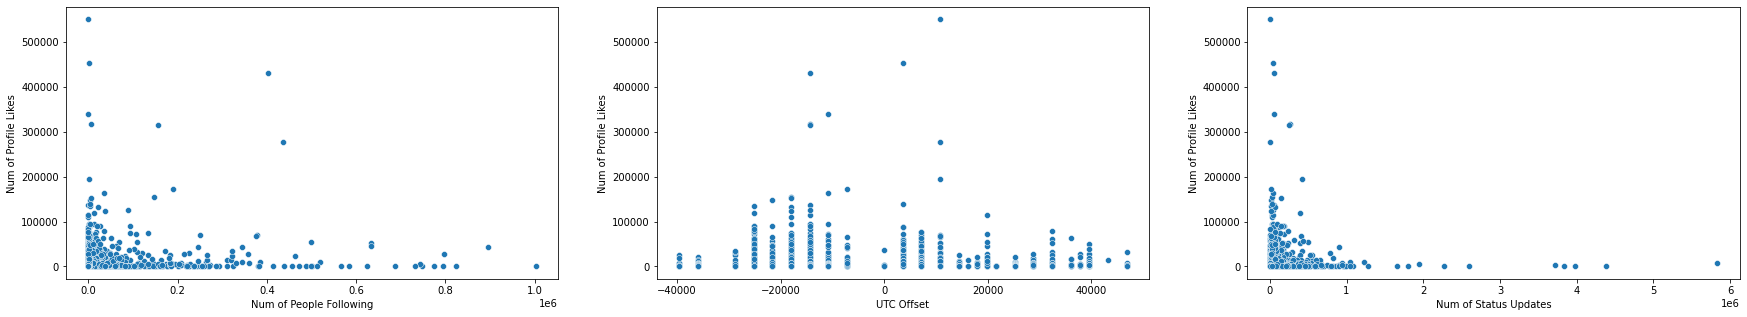

In [9]:
_, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(30,5))
sns.scatterplot(x='Num of People Following', y='Num of Profile Likes', data=df_train, ax=ax1)
sns.scatterplot(x='UTC Offset', y='Num of Profile Likes', data=df_train, ax=ax2)
sns.scatterplot(x='Num of Status Updates', y='Num of Profile Likes', data=df_train, ax=ax3)
plt.show()

Looking at the scatter plot above, it seems like there is no obvious relationship between the features and the target variables. However, we notice that the values of our target variables are condensed below 200000 likes. We can thus use that as a threshold for the outliers. We also notice that we can remove some outliers regarding the other features.

In [10]:
df_train = df_train.drop(df_train[df_train['Num of Profile Likes']>200000].index)
df_train = df_train.drop(df_train[df_train['Num of Profile Likes']<1].index)

Let's see how many observations we have left.

In [11]:
df_train.shape[0]

7203

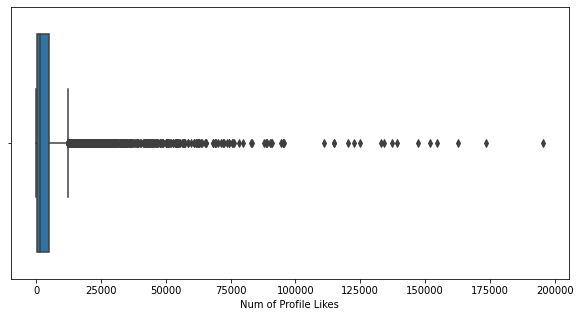

In [12]:
#Print a boxplot for our target variable
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['Num of Profile Likes'])
plt.show()

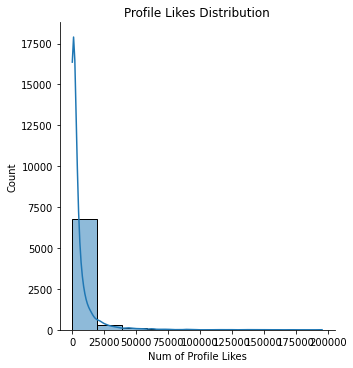

In [13]:
sns.displot(df_train['Num of Profile Likes'], bins=10, kde=True)
plt.ylabel('Count')
plt.title('Profile Likes Distribution')
plt.show()

Our distribution already looks better. However, it is still heavily skewed to the right. Let's apply log transformation to reduce skewness of the data. 

In [14]:
#Log transform the target variable
df_train['Num of Profile Likes'] = np.log1p(df_train['Num of Profile Likes'])

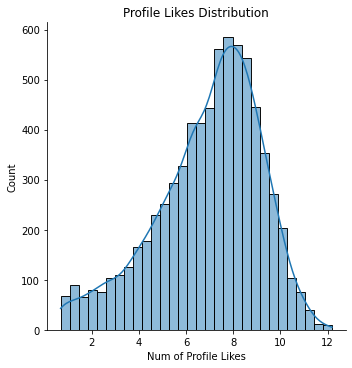

In [15]:
sns.displot(df_train['Num of Profile Likes'], bins=30, kde=True)
plt.ylabel('Count')
plt.title('Profile Likes Distribution')
plt.show()

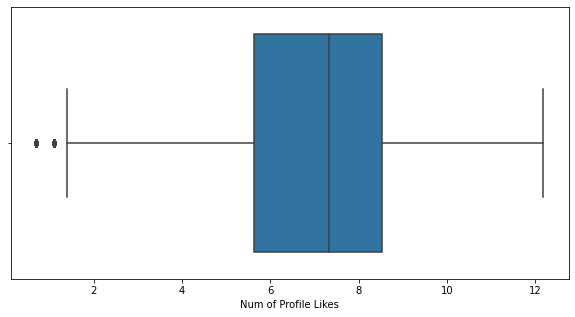

In [16]:
#Print a boxplot for our target variable after log transforming
plt.figure(figsize=(10,5))
sns.boxplot(x=df_train['Num of Profile Likes'])
plt.show()

Let's now look at our independent variables (features).

In [17]:
df_train.isnull().sum()

Id                                                0
User Name                                         0
Personal URL                                   4176
Profile Cover Image Status                       86
Profile Verification Status                       0
Profile Text Color                               64
Profile Page Color                               77
Profile Theme Color                              68
Is Profile View Size Customized?                  0
UTC Offset                                      442
Location                                       1366
Location Public Visibility                        0
User Language                                     0
Profile Creation Timestamp                        0
User Time Zone                                  442
Num of Followers                                  0
Num of People Following                           0
Num of Status Updates                             0
Num of Direct Messages                            0
Profile Cate

For columns that contain a lot of NaN values, we will replace their values by 1 when present and 0 otherwise.

In [18]:
df_train['Personal URL'] = df_train['Personal URL'].notnull().astype(int)
df_train['Location'] = df_train['Location'].notnull().astype(int)
df_test['Personal URL'] = df_test['Personal URL'].notnull().astype(int)
df_test['Location'] = df_test['Location'].notnull().astype(int)

In [19]:
df_train.isnull().sum()

Id                                               0
User Name                                        0
Personal URL                                     0
Profile Cover Image Status                      86
Profile Verification Status                      0
Profile Text Color                              64
Profile Page Color                              77
Profile Theme Color                             68
Is Profile View Size Customized?                 0
UTC Offset                                     442
Location                                         0
Location Public Visibility                       0
User Language                                    0
Profile Creation Timestamp                       0
User Time Zone                                 442
Num of Followers                                 0
Num of People Following                          0
Num of Status Updates                            0
Num of Direct Messages                           0
Profile Category               

In [20]:
#Turn column Profile Cover Image Status into binary variable.
def update_profile_image_status(x):
    x.loc[x['Profile Cover Image Status'] == "Set", 'Profile Cover Image Status'] = 1
    x.loc[x['Profile Cover Image Status'] == "Not set", 'Profile Cover Image Status'] = 0
    x['Profile Cover Image Status'] = x['Profile Cover Image Status'].fillna(0)
    return x

df_train = update_profile_image_status(df_train)
df_test = update_profile_image_status(df_test)

For non numerical features, let's see how many unique values they each contain.

In [21]:
print("Number of unique values for Profile Text Color", df_train['Profile Text Color'].value_counts().nunique())
print("Number of unique values for Profile Page Color", df_train['Profile Page Color'].value_counts().nunique())
print("Number of unique values for Profile Theme Color", df_train['Profile Theme Color'].value_counts().nunique())
print("Number of unique values for UTC Offset", df_train['UTC Offset'].value_counts().nunique())
print("Number of unique values for User Time Zone", df_train['User Time Zone'].value_counts().nunique())

Number of unique values for Profile Text Color 39
Number of unique values for Profile Page Color 40
Number of unique values for Profile Theme Color 39
Number of unique values for UTC Offset 24
Number of unique values for User Time Zone 61


Considering we have a lot of different unique values in each of the features above, we can use frequency encoding for these variables. However, they also contain some NaN values that we will need to fill the missing values. We will fill in the missing values with the most frequent elements. 

In [22]:
categorical_features_to_impute = ['Profile Text Color', 'Profile Page Color', 'Profile Theme Color', 'UTC Offset', 'User Time Zone']
df_train[categorical_features_to_impute] = df_train[categorical_features_to_impute].fillna(df_train[categorical_features_to_impute].mode().iloc[0])
df_test[categorical_features_to_impute] = df_test[categorical_features_to_impute].fillna(df_test[categorical_features_to_impute].mode().iloc[0])

In [23]:
df_train.isnull().sum()

Id                                              0
User Name                                       0
Personal URL                                    0
Profile Cover Image Status                      0
Profile Verification Status                     0
Profile Text Color                              0
Profile Page Color                              0
Profile Theme Color                             0
Is Profile View Size Customized?                0
UTC Offset                                      0
Location                                        0
Location Public Visibility                      0
User Language                                   0
Profile Creation Timestamp                      0
User Time Zone                                  0
Num of Followers                                0
Num of People Following                         0
Num of Status Updates                           0
Num of Direct Messages                          0
Profile Category                                0


Now that we have replaced NaNs with the most frequent element in each column. We will encode those categorical variables with their frequencies.

In [24]:
#Define function for frequency encoding
def encode_frequency_feature(x, feature_name):
    encode = x.groupby(feature_name).size() / len(x)
    x[feature_name] = x[feature_name].apply(lambda y: encode[y])
    return x

In [25]:
categorical_features_to_encode = categorical_features_to_impute
for idx,feature in enumerate(categorical_features_to_encode):
    df_train = encode_frequency_feature(df_train, feature)
    df_test = encode_frequency_feature(df_test, feature)

We have encoded our categorical features using their frequency.

In [26]:
df_train[categorical_features_to_encode]

,Profile Text Color,Profile Page Color,Profile Theme Color,UTC Offset,User Time Zone
0,0.000139,0.000139,0.000139,0.008191,0.005276
1,0.006109,0.006386,0.004443,0.239761,0.225045
2,0.000139,0.096071,0.000139,0.105512,0.069971
3,0.000139,0.000416,0.000139,0.239761,0.225045
4,0.000139,0.001666,0.140081,0.105512,0.069971
...,...,...,...,...,...
7495,0.000139,0.333611,0.140081,0.145634,0.136887
7496,0.021241,0.054561,0.107872,0.068027,0.000278
7497,0.176454,0.040955,0.000139,0.120228,0.002221
7498,0.002915,0.040955,0.001666,0.068027,0.033875


Let's see what is left for us to do.

In [27]:
df_train.isnull().sum()

Id                                              0
User Name                                       0
Personal URL                                    0
Profile Cover Image Status                      0
Profile Verification Status                     0
Profile Text Color                              0
Profile Page Color                              0
Profile Theme Color                             0
Is Profile View Size Customized?                0
UTC Offset                                      0
Location                                        0
Location Public Visibility                      0
User Language                                   0
Profile Creation Timestamp                      0
User Time Zone                                  0
Num of Followers                                0
Num of People Following                         0
Num of Status Updates                           0
Num of Direct Messages                          0
Profile Category                                0


We have some numerical features that contain NaNs. We could either fill those NaNs with the mean of the column or the median. In order to determine which is more appropriate, let's see if there are outliers for each column using box plots.

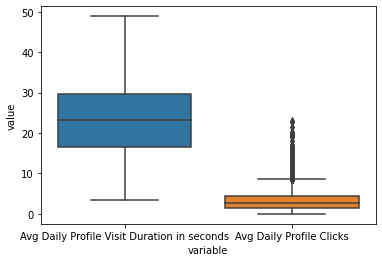

In [28]:
sns.boxplot(x='variable', y='value', data=pd.melt(df_train[['Avg Daily Profile Visit Duration in seconds', 'Avg Daily Profile Clicks']]))
plt.show()

We notice that the 'Avg Daily Profile Visit Duration in seconds' variable does not present any outliers. We can thus replace the missing values with the mean of the column.

In [29]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
column_to_impute = np.array(df_train['Avg Daily Profile Visit Duration in seconds']).reshape(-1,1)
mean_imputer.fit(column_to_impute)
df_train['Avg Daily Profile Visit Duration in seconds'] = mean_imputer.transform(column_to_impute)

In [30]:
test_column_to_impute = np.array(df_test['Avg Daily Profile Visit Duration in seconds']).reshape(-1,1)
mean_imputer.fit(test_column_to_impute)
df_test['Avg Daily Profile Visit Duration in seconds'] = mean_imputer.transform(test_column_to_impute)

We don't have any missing values anymore for'Avg Daily Profile Visit Duration in seconds' feature.

In [31]:
df_train['Avg Daily Profile Visit Duration in seconds'].isnull().sum()

0

Now, what to do with feature 'Avg Daily Profile Clicks' which has many outliers? Since there are many of them, we can impute missing values with the median since the mean is very sensitive to outliers.

In [32]:
median_imputer = SimpleImputer(missing_values=np.nan, strategy='median')
column_to_impute = np.array(df_train['Avg Daily Profile Clicks']).reshape(-1,1)
median_imputer = median_imputer.fit(column_to_impute)
df_train['Avg Daily Profile Clicks'] = median_imputer.transform(column_to_impute)

In [33]:
test_column_to_impute = np.array(df_test['Avg Daily Profile Clicks']).reshape(-1,1)
median_imputer = median_imputer.fit(test_column_to_impute)
df_test['Avg Daily Profile Clicks'] = median_imputer.transform(test_column_to_impute)

In [34]:
df_train['Avg Daily Profile Clicks'].isnull().sum()

0

In [35]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7203 entries, 0 to 7499
Data columns (total 24 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Id                                           7203 non-null   object 
 1   User Name                                    7203 non-null   object 
 2   Personal URL                                 7203 non-null   int64  
 3   Profile Cover Image Status                   7203 non-null   int64  
 4   Profile Verification Status                  7203 non-null   object 
 5   Profile Text Color                           7203 non-null   float64
 6   Profile Page Color                           7203 non-null   float64
 7   Profile Theme Color                          7203 non-null   float64
 8   Is Profile View Size Customized?             7203 non-null   bool   
 9   UTC Offset                                   7203 non-null   float64
 10  

We still have a few objects features. Let's see what to do with them.

In [36]:
df_train[['Id', 'User Name', 'Profile Verification Status', 'User Language', 'Location Public Visibility', 'Profile Creation Timestamp', 'Profile Category', 'Profile Image']].head()

,Id,User Name,Profile Verification Status,User Language,Location Public Visibility,Profile Creation Timestamp,Profile Category,Profile Image
0,AL85S14OMDPF01I9,Mf9vfld4Vfe,Verified,en,Enabled,Thu Nov 27 05:24:59 +0000 2008,business,AL85S14OMDPF01I9.png
1,HI11QOPD7BLJTO7Q,xl9gaGN0hxM_,Verified,en,Enabled,Fri Jan 15 18:00:46 +0000 2010,unknown,HI11QOPD7BLJTO7Q.png
2,JS49LP5P72RI1OQB,d_uiMm,Not verified,en,Enabled,Fri Oct 02 20:15:06 +0000 2009,unknown,JS49LP5P72RI1OQB.png
3,S0GDSC09MACCLBJP,hfylaRr,Verified,en,Enabled,Thu Feb 19 14:37:22 +0000 2009,business,S0GDSC09MACCLBJP.png
4,CRSEMK4QER6LDJSA,hRR1sDGlz5,Not verified,en,Enabled,Tue Mar 31 13:27:52 +0000 2009,unknown,CRSEMK4QER6LDJSA.png


In [37]:
df_train = df_train.drop(columns=['Id', 'User Name'])
df_test = df_test.drop(columns=['User Name'])

df_train.head()

,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,Location Public Visibility,...,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,Num of Profile Likes
0,0,1,Verified,0.000139,0.000139,0.000139,False,0.008191,0,Enabled,...,0.005276,95763,4289,30809,873,business,14.792,1.5761,AL85S14OMDPF01I9.png,7.943073
1,0,1,Verified,0.006109,0.006386,0.004443,False,0.239761,1,Enabled,...,0.225045,1018746,289,8150,290,unknown,8.183,11.2782,HI11QOPD7BLJTO7Q.png,7.125283
2,0,1,Not verified,0.000139,0.096071,0.000139,False,0.105512,1,Enabled,...,0.069971,13444,1876,4698,227,unknown,31.823,0.5725,JS49LP5P72RI1OQB.png,7.352441
3,1,0,Verified,0.000139,0.000416,0.000139,False,0.239761,1,Enabled,...,0.225045,339168,1148,53216,4035,business,23.052,4.0265,S0GDSC09MACCLBJP.png,8.755107
4,1,1,Not verified,0.000139,0.001666,0.140081,False,0.105512,1,Enabled,...,0.069971,9215,93,3271,130,unknown,8.418,3.9229,CRSEMK4QER6LDJSA.png,6.983790


Let's continue exploring our categorical features.

In [38]:
df_train['Profile Verification Status'].value_counts()

Verified        4634
Not verified    2017
Pending          552
Name: Profile Verification Status, dtype: int64

Considering 'Pending' status is not yet verified, we can merge pending and not verified together and turn our feature into a binary feature.

In [39]:
df_train['Profile Verification Status'].unique()

array(['Verified', 'Not verified', 'Pending'], dtype=object)

In [40]:
df_train['Profile Verification Status'] = np.where(df_train['Profile Verification Status'] == 'Verified', 1, 0)
df_test['Profile Verification Status'] = np.where(df_test['Profile Verification Status'] == 'Verified', 1, 0)

In [41]:
df_train['Profile Verification Status'].unique()

array([1, 0])

In [42]:
df_train.head()

,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,Location Public Visibility,...,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Profile Image,Num of Profile Likes
0,0,1,1,0.000139,0.000139,0.000139,False,0.008191,0,Enabled,...,0.005276,95763,4289,30809,873,business,14.792,1.5761,AL85S14OMDPF01I9.png,7.943073
1,0,1,1,0.006109,0.006386,0.004443,False,0.239761,1,Enabled,...,0.225045,1018746,289,8150,290,unknown,8.183,11.2782,HI11QOPD7BLJTO7Q.png,7.125283
2,0,1,0,0.000139,0.096071,0.000139,False,0.105512,1,Enabled,...,0.069971,13444,1876,4698,227,unknown,31.823,0.5725,JS49LP5P72RI1OQB.png,7.352441
3,1,0,1,0.000139,0.000416,0.000139,False,0.239761,1,Enabled,...,0.225045,339168,1148,53216,4035,business,23.052,4.0265,S0GDSC09MACCLBJP.png,8.755107
4,1,1,0,0.000139,0.001666,0.140081,False,0.105512,1,Enabled,...,0.069971,9215,93,3271,130,unknown,8.418,3.9229,CRSEMK4QER6LDJSA.png,6.983790


We convert our boolean feature to int.

In [43]:
df_train['Is Profile View Size Customized?'] = df_train['Is Profile View Size Customized?'].astype(int)
df_test['Is Profile View Size Customized?'] = df_test['Is Profile View Size Customized?'].astype(int)

In [44]:
df_train['Location Public Visibility'].value_counts()

Enabled     3428
Disabled    2014
enabled      865
disabled     533
??           363
Name: Location Public Visibility, dtype: int64

Let's combine some of the values in this feature.

In [45]:
df_train.loc[df_train['Location Public Visibility'] == '??', 'Location Public Visibility'] = 'unknown'
df_train['Location Public Visibility'] = df_train['Location Public Visibility'].str.lower()
df_test.loc[df_test['Location Public Visibility'] == '??', 'Location Public Visibility'] = 'unknown'
df_test['Location Public Visibility'] = df_test['Location Public Visibility'].str.lower()

In [46]:
df_train['Location Public Visibility'].unique()

array(['enabled', 'disabled', 'unknown'], dtype=object)

In [47]:
df_train = encode_frequency_feature(df_train, 'Location Public Visibility')
df_test = encode_frequency_feature(df_test, 'Location Public Visibility')

In [48]:
df_train['Location Public Visibility'].value_counts()

0.596002    4293
0.353603    2547
0.050396     363
Name: Location Public Visibility, dtype: int64

In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7203 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Personal URL                                 7203 non-null   int64  
 1   Profile Cover Image Status                   7203 non-null   int64  
 2   Profile Verification Status                  7203 non-null   int64  
 3   Profile Text Color                           7203 non-null   float64
 4   Profile Page Color                           7203 non-null   float64
 5   Profile Theme Color                          7203 non-null   float64
 6   Is Profile View Size Customized?             7203 non-null   int64  
 7   UTC Offset                                   7203 non-null   float64
 8   Location                                     7203 non-null   int64  
 9   Location Public Visibility                   7203 non-null   float64
 10  

Let's study User Language.

In [50]:
df_train['User Language'].value_counts()

en       5147
es        849
pt        249
fr        215
tr        135
it        113
ja         94
de         82
en-gb      57
ar         53
nl         47
ko         46
ru         44
id         17
pl         15
cs          7
sv          6
ca          5
fi          5
el          4
zh-cn       3
th          2
da          2
sk          2
hu          1
zh-TW       1
uk          1
sr          1
Name: User Language, dtype: int64

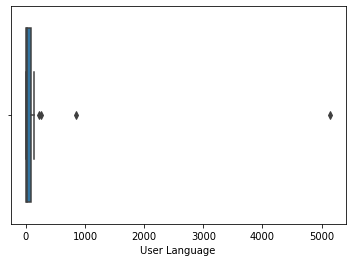

In [51]:
sns.boxplot(x=df_train['User Language'].value_counts())
plt.show()

Merge english and british english.

In [52]:
df_train.loc[df_train['User Language'] == 'en-gb', 'User Language'] = 'en'
df_train.loc[df_train['User Language'] == 'zh-cn', 'User Language'] = 'zh'
df_train.loc[df_train['User Language'] == 'zh-TW', 'User Language'] = 'zh'
df_test.loc[df_test['User Language'] == 'en-gb', 'User Language'] = 'en'
df_test.loc[df_test['User Language'] == 'zh-cn', 'User Language'] = 'zh'
df_test.loc[df_test['User Language'] == 'zh-TW', 'User Language'] = 'zh'

In [53]:
df_train['User Language'].value_counts()

en    5204
es     849
pt     249
fr     215
tr     135
it     113
ja      94
de      82
ar      53
nl      47
ko      46
ru      44
id      17
pl      15
cs       7
sv       6
fi       5
ca       5
zh       4
el       4
da       2
th       2
sk       2
sr       1
hu       1
uk       1
Name: User Language, dtype: int64

We now use frequency encoding to encode our feature.

In [54]:
df_train = encode_frequency_feature(df_train, 'User Language')
df_test = encode_frequency_feature(df_test, 'User Language')

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7203 entries, 0 to 7499
Data columns (total 22 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Personal URL                                 7203 non-null   int64  
 1   Profile Cover Image Status                   7203 non-null   int64  
 2   Profile Verification Status                  7203 non-null   int64  
 3   Profile Text Color                           7203 non-null   float64
 4   Profile Page Color                           7203 non-null   float64
 5   Profile Theme Color                          7203 non-null   float64
 6   Is Profile View Size Customized?             7203 non-null   int64  
 7   UTC Offset                                   7203 non-null   float64
 8   Location                                     7203 non-null   int64  
 9   Location Public Visibility                   7203 non-null   float64
 10  

Let's drop the profile image.

In [56]:
df_test.columns

Index(['Id', 'Personal URL', 'Profile Cover Image Status',
       'Profile Verification Status', 'Profile Text Color',
       'Profile Page Color', 'Profile Theme Color',
       'Is Profile View Size Customized?', 'UTC Offset', 'Location',
       'Location Public Visibility', 'User Language',
       'Profile Creation Timestamp', 'User Time Zone', 'Num of Followers',
       'Num of People Following', 'Num of Status Updates',
       'Num of Direct Messages', 'Profile Category',
       'Avg Daily Profile Visit Duration in seconds',
       'Avg Daily Profile Clicks', 'Profile Image'],
      dtype='object')

In [57]:
df_train = df_train.drop(columns=['Profile Image'])
df_test = df_test.drop(columns=['Profile Image'])

In [58]:
df_train['Profile Category'].unique()

array(['business', 'unknown', 'celebrity', 'government', ' '],
      dtype=object)

In [59]:
df_train.loc[df_train['Profile Category'] == ' ', 'Profile Category'] = 'unknown'
df_test.loc[df_test['Profile Category'] == ' ', 'Profile Category'] = 'unknown'

In [60]:
df_train['Profile Category'].unique()

array(['business', 'unknown', 'celebrity', 'government'], dtype=object)

We know encode by frequency the feature 'Profile Category'

In [61]:
df_train = encode_frequency_feature(df_train, 'Profile Category')
df_test = encode_frequency_feature(df_test, 'Profile Category')

In [62]:
df_train['Profile Category'].unique()

array([0.24670276, 0.47355269, 0.19047619, 0.08926836])

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7203 entries, 0 to 7499
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Personal URL                                 7203 non-null   int64  
 1   Profile Cover Image Status                   7203 non-null   int64  
 2   Profile Verification Status                  7203 non-null   int64  
 3   Profile Text Color                           7203 non-null   float64
 4   Profile Page Color                           7203 non-null   float64
 5   Profile Theme Color                          7203 non-null   float64
 6   Is Profile View Size Customized?             7203 non-null   int64  
 7   UTC Offset                                   7203 non-null   float64
 8   Location                                     7203 non-null   int64  
 9   Location Public Visibility                   7203 non-null   float64
 10  

In [64]:
def transform_timestamp(x):
    #Get Year and Month information
    df_year = x['Profile Creation Timestamp'].str.split(" ", expand=True)[5]
    df_month = x['Profile Creation Timestamp'].str.split(" ", expand=True)[1]
    #Map month string to numerical value
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    df_month = df_month.map(months)
    #Subtract months
    df_duration = df_year.apply(lambda y: (2020-int(y))*24)
    df_duration = df_duration - df_month
    #Rename column, add to df_train and drop timestamp
    df_duration = df_duration.astype(int)
    df_duration.rename('Months Since Profile Creation')
    x['Months Since Profile Creation'] = df_duration
    x = x.drop(columns='Profile Creation Timestamp', axis=1)
    return x

In [65]:
df_train = transform_timestamp(df_train)
df_test = transform_timestamp(df_test)

In [66]:
df_train.head(5)

,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,Location Public Visibility,...,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Num of Profile Likes,Months Since Profile Creation
0,0,1,1,0.000139,0.000139,0.000139,0,0.008191,0,0.596002,...,0.005276,95763,4289,30809,873,0.246703,14.792,1.5761,7.943073,277
1,0,1,1,0.006109,0.006386,0.004443,0,0.239761,1,0.596002,...,0.225045,1018746,289,8150,290,0.473553,8.183,11.2782,7.125283,239
2,0,1,0,0.000139,0.096071,0.000139,0,0.105512,1,0.596002,...,0.069971,13444,1876,4698,227,0.473553,31.823,0.5725,7.352441,254
3,1,0,1,0.000139,0.000416,0.000139,0,0.239761,1,0.596002,...,0.225045,339168,1148,53216,4035,0.246703,23.052,4.0265,8.755107,262
4,1,1,0,0.000139,0.001666,0.140081,0,0.105512,1,0.596002,...,0.069971,9215,93,3271,130,0.473553,8.418,3.9229,6.983790,261


In [67]:
df_test.head(5)

,Id,Personal URL,Profile Cover Image Status,Profile Verification Status,Profile Text Color,Profile Page Color,Profile Theme Color,Is Profile View Size Customized?,UTC Offset,Location,...,User Language,User Time Zone,Num of Followers,Num of People Following,Num of Status Updates,Num of Direct Messages,Profile Category,Avg Daily Profile Visit Duration in seconds,Avg Daily Profile Clicks,Months Since Profile Creation
0,49I3SOKLI2CMNGP4,0,1,0,0.0004,0.0004,0.0004,0,0.1084,1,...,0.7228,0.0256,31528,2148,12926,469,0.2416,13.827,3.4062,257
1,727IRIR59A3P88LK,0,0,0,0.0140,0.0024,0.0004,0,0.0016,1,...,0.7228,0.0016,42857,262,11678,1806,0.0884,24.019,3.2656,256
2,LN95SD15SRPCEE8F,1,1,1,0.0004,0.0664,0.1412,0,0.1540,1,...,0.7228,0.1468,40237847,392,9395,59247,0.4848,26.011,12.1619,213
3,TB11I7F0PN033D4T,0,1,1,0.0044,0.0032,0.0252,0,0.1540,1,...,0.7228,0.1468,230166,702,10507,2695,0.1852,26.127,2.1131,308
4,32PSGCK5PATHMR07,1,1,0,0.0004,0.3328,0.1032,0,0.2368,1,...,0.7228,0.2228,1199,1701,1022,8,0.4848,17.878,3.9660,186


In [68]:
#Check which features are highly correlated with the target variable
correlation_matrix = df_train.corr()[['Num of Profile Likes']].sort_values('Num of Profile Likes')
correlation_matrix

,Num of Profile Likes
Personal URL,-0.534665
Profile Category,-0.245915
Profile Page Color,-0.149611
Is Profile View Size Customized?,-0.147245
Profile Text Color,-0.126374
Profile Theme Color,-0.094506
Profile Cover Image Status,-0.060876
Num of Followers,-0.048903
Avg Daily Profile Visit Duration in seconds,-0.001626
Num of Direct Messages,0.003027


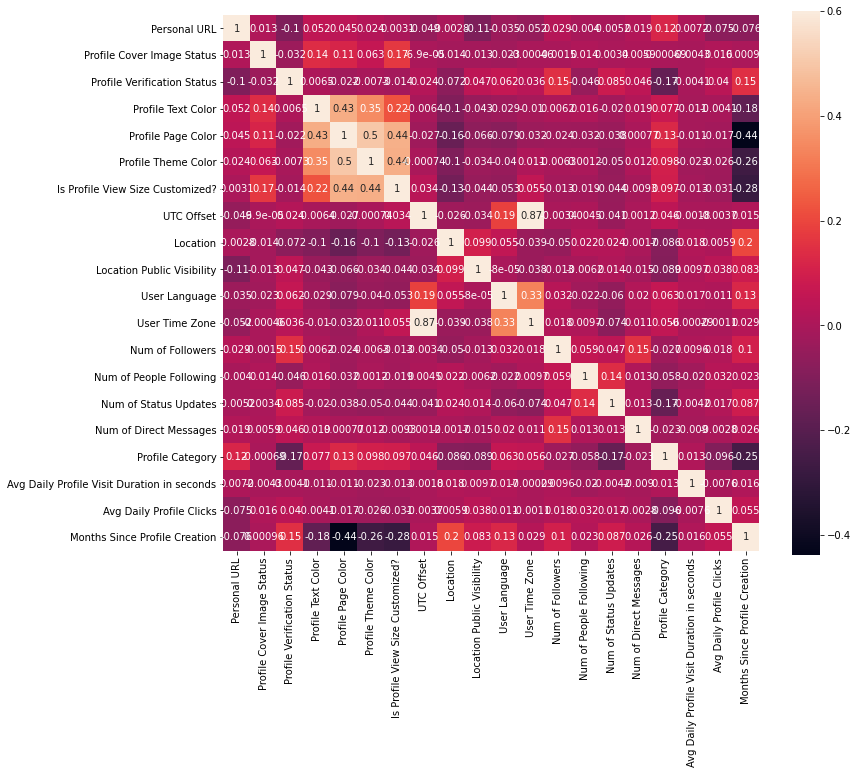

In [69]:
#Plot correlation coefficients
plt.figure(figsize=(12,10))
sns.heatmap(df_train.drop('Num of Profile Likes',axis=1).corr(), vmax=0.6, square=True, annot=True)
plt.show()

Now that we have cleaned our data, let's see where we are at regarding outliers.

In [70]:
first_batch = ['Num of Followers', 'Num of People Following', 'Num of Status Updates', 'Num of Direct Messages', 'Avg Daily Profile Visit Duration in seconds', 'Avg Daily Profile Clicks', 'Months Since Profile Creation']

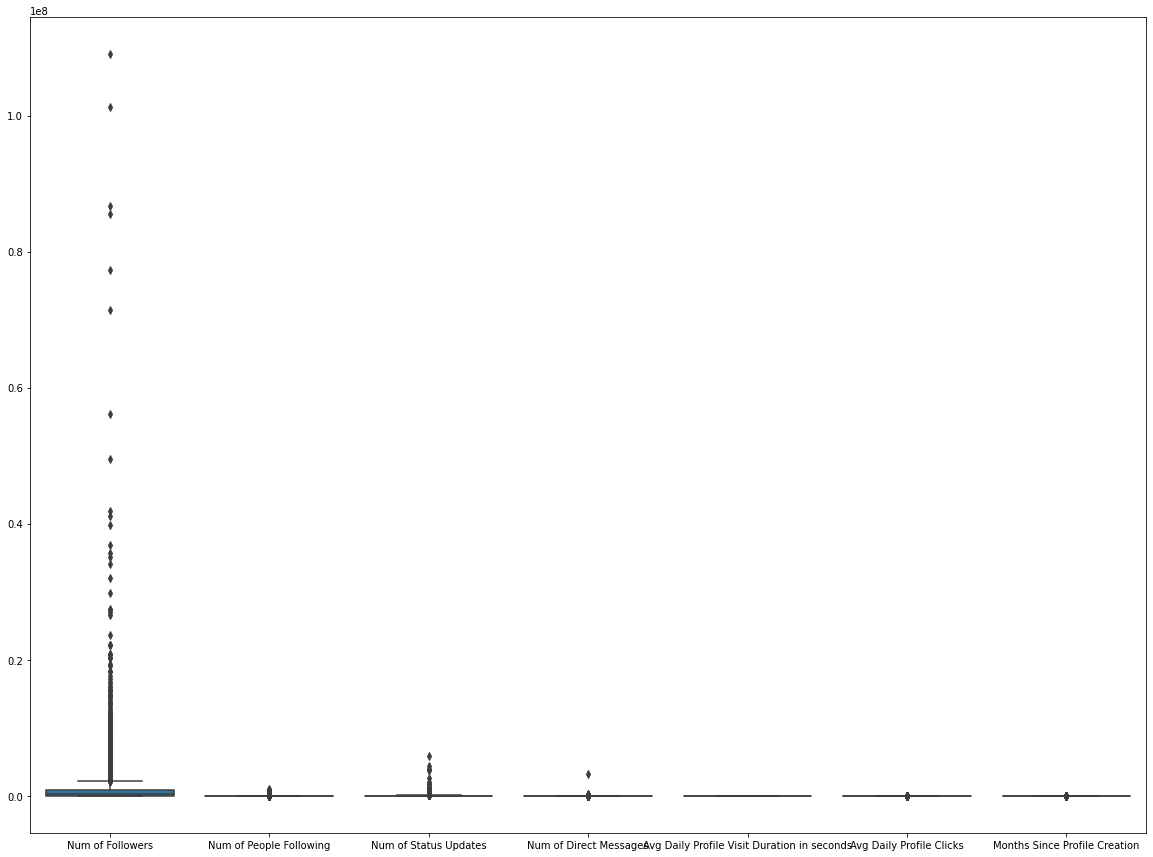

In [71]:
plt.figure(figsize=(20,15))
sns.boxplot(data=df_train[first_batch])
plt.show()

We thus see that some features contain a high number of outliers. We need to deal with some of them. 

Num of Followers                               16.447241
Num of People Following                        11.362380
Num of Status Updates                          21.345917
Num of Direct Messages                         80.305365
Avg Daily Profile Visit Duration in seconds     0.028476
Avg Daily Profile Clicks                        1.910883
Months Since Profile Creation                  -1.026044
dtype: float64


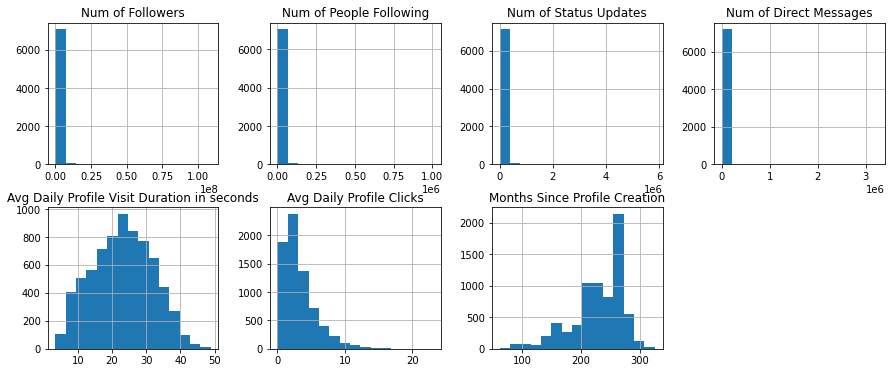

In [72]:
print(df_train[first_batch].skew())
df_train[first_batch].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()

Num of Followers                                7.598866
Num of People Following                        12.858043
Num of Status Updates                          20.070271
Num of Direct Messages                          8.787477
Avg Daily Profile Visit Duration in seconds     0.046791
Avg Daily Profile Clicks                        1.805910
Months Since Profile Creation                  -1.113439
dtype: float64


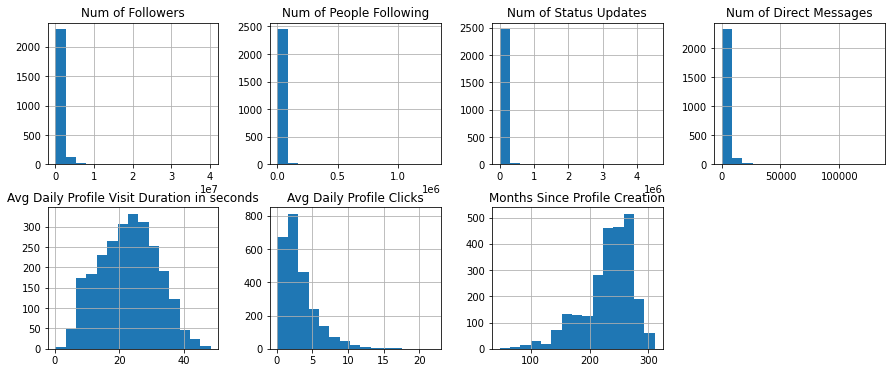

In [73]:
print(df_test[first_batch].skew())
df_test[first_batch].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()

We see that 'Avg Daily Profile Visit Duration in seconds' is more or less normally distributed. Same goes for 'Months since profile creation' We therefore do not need to do much about it. The other features are however heavily skewed and we will need to deal with them.

In [74]:
first_batch.remove('Avg Daily Profile Visit Duration in seconds')
first_batch.remove('Months Since Profile Creation')

Let's complete a log transform of our skewed variables to see if we can minimize the skewness.

In [75]:
df_train[first_batch] = np.log1p(df_train[first_batch])
df_test[first_batch] = np.log1p(df_test[first_batch])

TRAIN after log transform

Num of Followers           -0.454220
Num of People Following     0.196607
Num of Status Updates      -0.251608
Num of Direct Messages     -0.320481
Avg Daily Profile Clicks    0.307729
dtype: float64


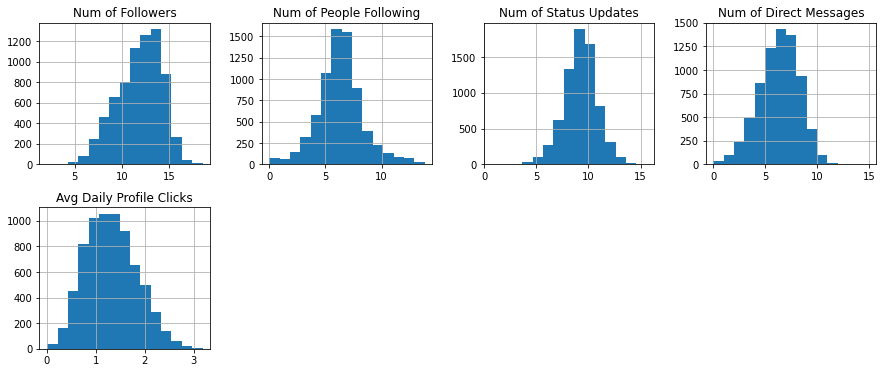

In [76]:
print(df_train[first_batch].skew())
df_train[first_batch].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()

Num of Followers           -0.504948
Num of People Following     0.150684
Num of Status Updates      -0.436475
Num of Direct Messages     -0.307674
Avg Daily Profile Clicks    0.323591
dtype: float64


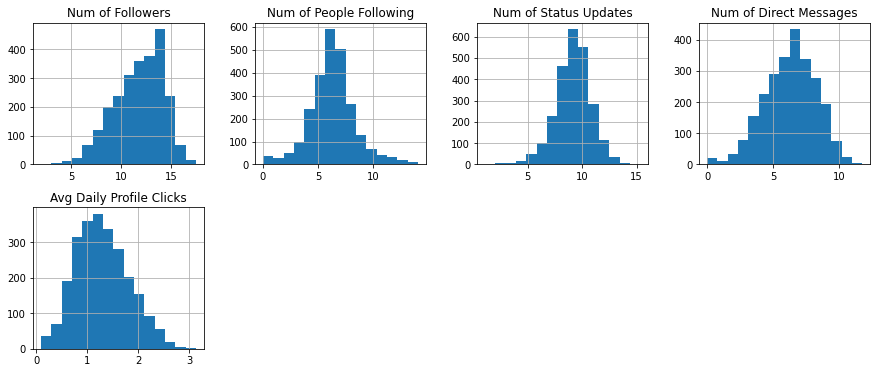

In [77]:
print(df_test[first_batch].skew())
df_test[first_batch].hist(bins=15, figsize=(15, 6), layout=(2, 4))
plt.show()

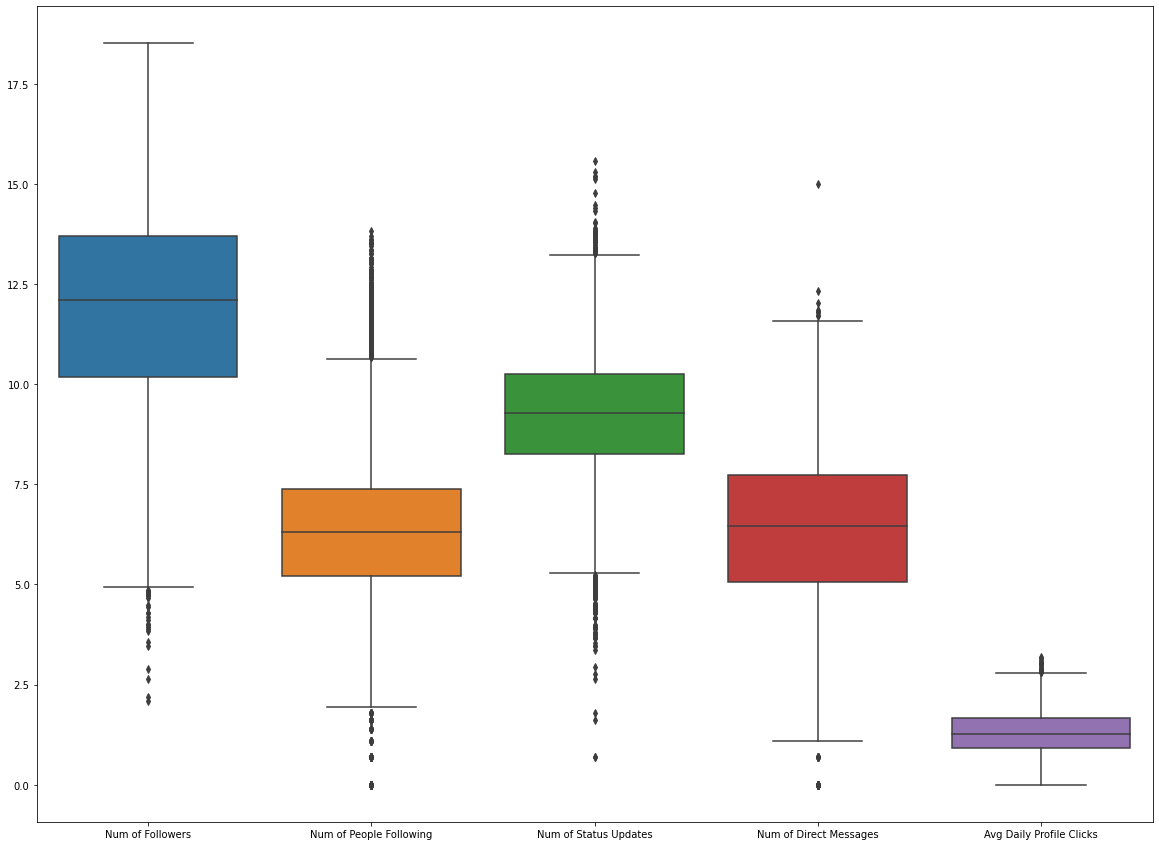

In [78]:
plt.figure(figsize=(20,15))
sns.boxplot(data=df_train[first_batch])
plt.show()

In [79]:
df_train.to_csv("../data/preprocessed_train_data.csv", index=False)
df_test.to_csv("../data/preprocessed_test_data.csv", index=False)